# Heat equation - Retrieving operator through ODE solving

In [10]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint as odeint

from graphic_tools import simple_plotter, show_state
from heat import get_heat, get_heat_grad_t, get_heat_fd, get_heat_fe

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

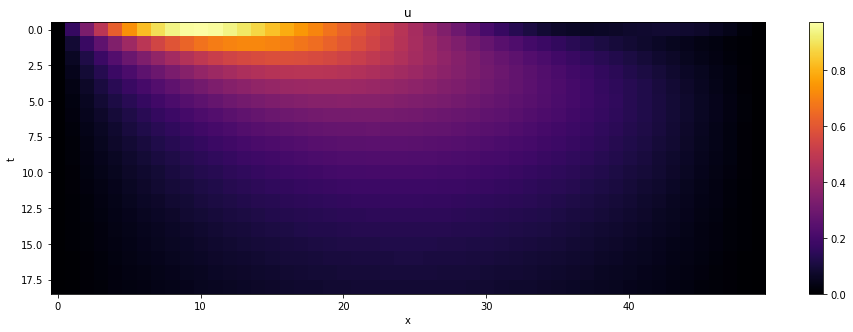

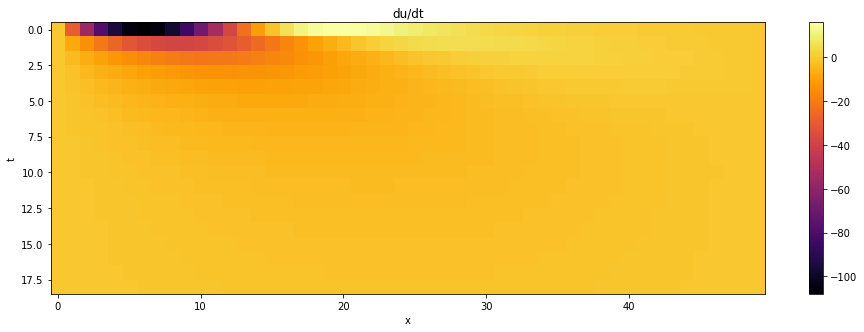

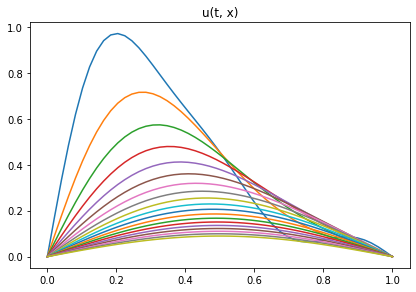

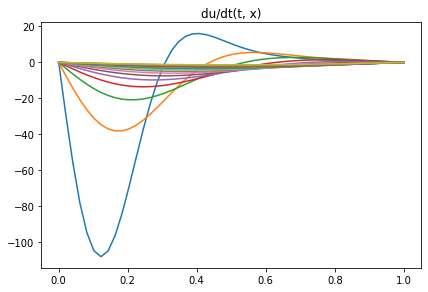

In [12]:
u_true, cn = get_heat(0.2, 0., 1., 0., 20, 50, True)
g_u_true = get_heat_grad_t(0.2, 0., 1., 0., 20, 50, cn)

show_state(u_true[1:], 'u')
show_state(g_u_true[1:], 'du/dt')

simple_plotter(u_true[1:], 'u(t, x)')
simple_plotter(g_u_true[1:], 'du/dt(t, x)') 

### Different methods

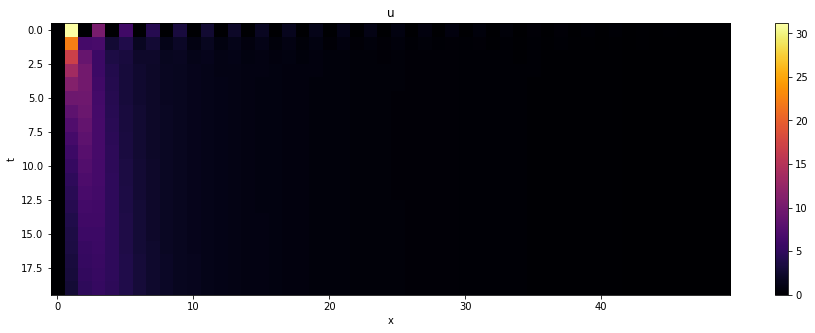

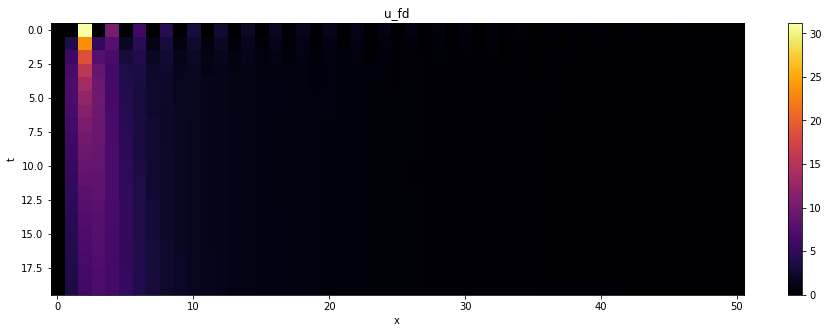

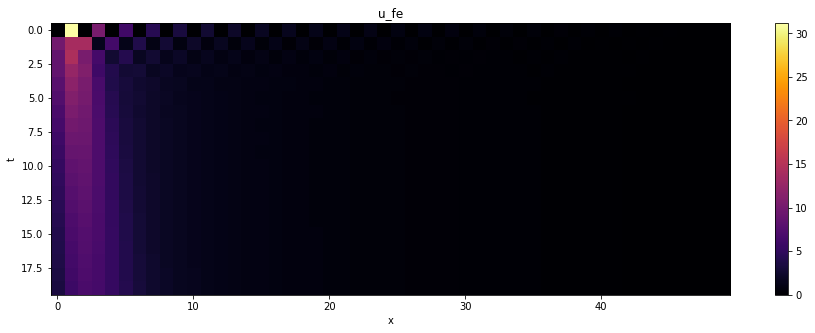

In [18]:
u, _ = get_heat(0.001, 0., 1., 0., 20, 50)
u_fd, _ = get_heat_fd(0.001, 0., 1., 0., 20, 50)
u_fe, _ = get_heat_fe(0.001, 0., 1., 0., 20, 50)

# Keep initial conditions. Change if start from t=1
show_state(u[:], 'u')
show_state(u_fd[:], 'u_fd')
show_state(u_fe[:], 'u_fe')

---

## Get operator F

### Definition of Model used by ODE solver

In [ ]:
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Sigmoid(),
            nn.Linear(50, 2)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

### Implementation of the neural ODE

Let's now write our neural ODE. In a first time we will generate some data and
process them in a format usable by PyTorch and the ODESolver (torchdiffeq).

In [19]:
def get_batch(t_max, x_max, t_n, x_n, x_batch_size, rand=True):
    # We generate our time and space axis
    t_range = np.linspace(0., t_max, t_n)[1:]
    x_range = np.linspace(0., x_max, x_n)
    
    # Then compute a snapshot of the solution u(t, x).
    u, _ = get_heat(t_max, 0.0, x_max, 0.0, t_n, x_n, rand)
    u_t = torch.from_numpy(u[1:,:]).float() # Convert to Tensor
    
    # Select random indexes for our training batch
    rand_idx = np.random.choice(np.arange(x_n, dtype=np.int64), x_batch_size, replace=False)
    rand_idx = np.sort(rand_idx)
    
    # Get the values from the x-axis and the solution u(0, x)
    batch_x0 = torch.from_numpy(x_range[rand_idx]).float()[:, np.newaxis]
    batch_u0 = u_t[0, rand_idx, np.newaxis]  # Get u(0, x)
    
    # Concatenate x and u0 values = dimension (x_batch_size, 2)
    batch_xu0 = torch.cat((batch_x0, batch_u0), 1)

    # Get the set of time values from the t-axis used by ODE solver.  dimension (t_max)
    batch_t = torch.from_numpy(t_range).float()
    
    # Get the values of u for each instant t of the batch_t
    batch_u = torch.stack([u_t[i, rand_idx] for i in range(0, t_n - 1)], dim=0)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    batch_x = torch.from_numpy(x_range[rand_idx]).float().repeat(t_n - 1, 1)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    
    # Concatenate x and u values.  dimension (t_max, x_batch_size, 2)
    batch_xu = torch.cat((batch_x, batch_u), 2)
    
    return batch_t, batch_xu0, batch_xu

In [20]:
# t, b0, by = get_batch(0.2, 1., 10, 10, 5, False)
# print(t.size())
# print(b0.size())
# print(by.size())

torch.Size([9])
torch.Size([5, 2])
torch.Size([9, 5, 2])


Let's write a small training loop for our neural ode.

In [ ]:
def training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, batch_size=10):
    loss_fn = nn.MSELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.003)

    for e in range(1, epochs + 1):
        loss_tot = 0
        for i in range(int(x_n / batch_size)):
            optimizer.zero_grad()
            
            t, b0, bu = get_batch(1., 1., t_n, x_n, batch_size)
            pred_u = odeint(net, b0, t)  # net = F
            #loss = torch.mean(torch.square(pred_u[:,:,0] - bu[:,:,0])) + torch.mean(torch.square(pred_u[:,:,1] - bu[:,:,1])) # loss_fn(pred_u, u_true)
            
            loss1 = loss_fn(pred_u[:,:,0], bu[:,:,0]) 
            loss2 = loss_fn(pred_u[:,:,1], bu[:,:,1])
            loss = loss1 + loss2
            loss_tot += loss.item()
            loss.backward(retain_graph=True)
            
            optimizer.step()
        
        if e % 10 == 0:
            t, b0, bu = get_batch(1., 1., t_n, x_n, x_n)
            visualize_u_from_F(net, t, b0)
            print('epoch %d f loss %f'%(e, float(loss_tot / float(x_n / batch_size))))
            
    return net

In [ ]:
net = ODEModel()
F = training_ode_solver_net(net, 60, 20, 100, 50)

## Visualization

In [ ]:
def visualize_F_with_u(F, t_n=20, x_n=100):
    u, x = np.mgrid[-0.2:0.2:10j, 0.:1.:10j]
    grid_xu = torch.from_numpy(np.stack([x, u], -1).reshape(x_n * x_n, 2)).float()
    t = torch.Tensor(np.linspace(0., 1.0, t_n))
    u_m = np.zeros((t_n, x_n * x_n, 2))

    for i in range(1, t_n):
        tmp = F(0, grid_xu).detach().numpy()
        u_m[i] = tmp
    
    color = ['b','r','g','y']
    width=200
    height=150
    
    for i in [5]: # range(1, t_n, 5):
        xlims = (u_m[i, :, 0].min(), u_m[i, :, 0].max())
        ylims = (u_m[i, :, 1].min(), u_m[i, :, 1].max())
        dx = xlims[1] - xlims[0]
        dy = ylims[1] - ylims[0]
        
        buffer = np.zeros((height+1, width+1))
        
        for j, p in enumerate(u_m[i, :, :]):
            x0 = int(round(((p[0] - xlims[0]) / dx) * width))
            y0 = int(round((1 - (p[1] - ylims[0]) / dy) * height))
            buffer[y0, x0] += 0.3
            if buffer[y0, x0] > 1.0: buffer[y0, x0] = 1.0
        
        ax_extent = list(xlims)+list(ylims)
        plt.figure(dpi=150)
        plt.imshow(
            buffer,
            vmin=0,
            vmax=1, 
            cmap=plt.get_cmap('hot'),
            interpolation='lanczos',
            aspect='auto',
            extent=ax_extent)
            
    return u_m

In [ ]:
# W compute u(t,x) to use the same set of constants c for du/dt.
u, cn = get_heat(1., 0., 1., 0., 20, 50, True)
g_u = get_heat_grad_t(1.0, 0.0, 1.0, 0.0, 10, 50, cn)[1:]
simple_plotter(g_u, 'du/dt')
# test = visualize_F_with_u(F, 20, 10)

What is happening here ?
We display du/dt for a set of grid points (t, x) to have an overall idea of the derivative shape.
With the operator F, we provide a different set of values, has we generate grid points (x, u).
While the results will be different, it clearly apppears we do not get the same shapes.


In [ ]:
def visualize_u_from_F(F, t, u0): # t_n, x_n, t_max, x_max, t_idx=0:
    plt.figure(dpi=150)
    pred_u = odeint(F, u0, t).detach().numpy()
    color = ['b','r','g','y']
    i = t.shape[0] - 1
    
    #plt.plot(pred_u[:, :, 0], pred_u[:, :, 1], 'b--')
        
    for j in range(int(len(pred_u[i]))):
        zx = pred_u[i,j,0]
        zu = pred_u[i,j,1]
        plt.scatter(zx, zu, s=5, c='b')

In [ ]:
u_true, cn = get_heat(1., 0., 1., 0., 20, 50, False)
simple_plotter(u_true[1:3], 'u(t, x)')

t, u0, _ = get_batch(1., 1., 20, 100, 100)          
visualize_u_from_F(F, t[1:3], u0) #  20, 100, 1., 1., 19

---

## Results analysis

As the earlier visualization offers some results which appears to be different from the expected values, we perform some errors analysis.

In [ ]:
def analyze_error(F, u, g_u):
    return np.mean(np.abs(F @ u - g_u))